  Train len: 125
   Test len: 25
Train Epoch: 1 [0/125 (0%)]	Loss: 2840.157187
Train Epoch: 1 [50/125 (40%)]	Loss: 2836.004375
Train Epoch: 1 [100/125 (80%)]	Loss: 3141.635313
====> Epoch: 1 Average loss: 2897.5704
====> Test set loss: 2800.8206
Train Epoch: 2 [0/125 (0%)]	Loss: 2822.442187
Train Epoch: 2 [50/125 (40%)]	Loss: 2791.071250
Train Epoch: 2 [100/125 (80%)]	Loss: 2765.506250
====> Epoch: 2 Average loss: 2797.2049
====> Test set loss: 2768.7238
Train Epoch: 3 [0/125 (0%)]	Loss: 2689.470625
Train Epoch: 3 [50/125 (40%)]	Loss: 3020.491250
Train Epoch: 3 [100/125 (80%)]	Loss: 2670.623750
====> Epoch: 3 Average loss: 2755.3611
====> Test set loss: 2753.0813
Train Epoch: 4 [0/125 (0%)]	Loss: 2692.617500
Train Epoch: 4 [50/125 (40%)]	Loss: 2630.705000
Train Epoch: 4 [100/125 (80%)]	Loss: 2709.602812
====> Epoch: 4 Average loss: 2685.3148
====> Test set loss: 2668.8981
Train Epoch: 5 [0/125 (0%)]	Loss: 2643.045625
Train Epoch: 5 [50/125 (40%)]	Loss: 2677.219375
Train Epoch: 5 [100/1

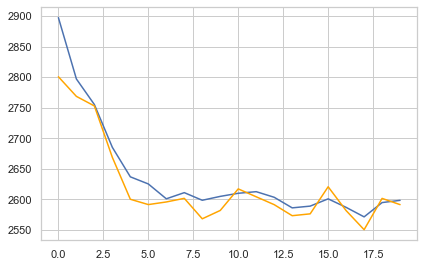

In [33]:
from __future__ import print_function
import argparse
import torch
import torch.utils.data
import math
import os
import natsort
import torchvision
from PIL import Image
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
import torch.utils.data as data

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import style

style.use('fivethirtyeight')
sns.set(style='whitegrid',color_codes=True)

parser = argparse.ArgumentParser(description='VAE MNIST Example')
parser.add_argument('-f')
parser.add_argument('--batch-size', type=int, default=40, metavar='N',
                    help='input batch size for training (default: 128)')
parser.add_argument('--epochs', type=int, default=10, metavar='N',
                    help='number of epochs to train (default: 10)')
parser.add_argument('--no-cuda', action='store_true', default=False,
                    help='disables CUDA training')
parser.add_argument('--seed', type=int, default=1, metavar='S',
                    help='random seed (default: 1)')
parser.add_argument('--log-interval', type=int, default=2, metavar='N',
                    help='how many batches to wait before logging training status')
args = parser.parse_args()
args.cuda = not args.no_cuda and torch.cuda.is_available()

torch.manual_seed(args.seed)

device = torch.device("cuda" if args.cuda else "cpu")

kwargs = {'num_workers': 1, 'pin_memory': True} if args.cuda else {}

class CustomDataset(data.Dataset):
    def __init__(self, main_dir, transform):
        self.main_dir = main_dir
        self.transform = transform
        all_imgs = os.listdir(main_dir)
        self.total_imgs = natsort.natsorted(all_imgs)

    def __len__(self):
        return len(self.total_imgs)

    def __getitem__(self, idx):
        img_loc = os.path.join(self.main_dir, self.total_imgs[idx])
        image = Image.open(img_loc).convert("RGB")
        tensor_image = self.transform(image)
        return tensor_image
    

EPOCHS = 20
BATCH_SIZE = 25
LEARNING_RATE = 0.003
IMG_SIZE = 64
CONV_SIZE = math.floor((((IMG_SIZE-2)/2)-2)/2)
INPUT_SIZE = (IMG_SIZE**2)*BATCH_SIZE

TRAIN_DATA_PATH = r"C:\Users\Administrator\Desktop\programming\datasets\images\lungs_kaggle\train\normal"
TEST_DATA_PATH = r"C:\Users\Administrator\Desktop\programming\datasets\images\lungs_kaggle\valid\normal"

TRANSFORM_IMG = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize(IMG_SIZE),
    transforms.CenterCrop(IMG_SIZE),
    transforms.ToTensor()])


train_data = CustomDataset(TRAIN_DATA_PATH, transform=TRANSFORM_IMG)
train_loader = data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True,  num_workers=0)

test_data = CustomDataset(TEST_DATA_PATH, transform=TRANSFORM_IMG)
test_loader = data.DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)

print('  Train len:',len(train_data))
print('   Test len:',len(test_data))

size5 = 256
size4 = 128
size3 = 64
size2 = 32
size1 = 16

class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(INPUT_SIZE, size5)
        self.fc2 = nn.Linear(size5, size4)
        self.fc3 = nn.Linear(size4, size3)
        self.fc4 = nn.Linear(size3, size2)
        
        self.fc51 = nn.Linear(size2, size1)
        self.fc52 = nn.Linear(size2, size1)
        self.fc6 = nn.Linear(size1, size2)
        
        self.fc7 = nn.Linear(size2, size3)
        self.fc8 = nn.Linear(size3, size4)
        self.fc9 = nn.Linear(size4, size5)
        self.fc10 = nn.Linear(size5, INPUT_SIZE)

    def encode(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        return self.fc51(x), self.fc52(x)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        z = F.relu(self.fc6(z))
        z = F.relu(self.fc7(z))
        z = F.relu(self.fc8(z))
        z = F.relu(self.fc9(z))
        return torch.sigmoid(self.fc10(z))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, INPUT_SIZE))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, INPUT_SIZE), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD

train_losses = []
def train(epoch):
    model.train()
    train_loss = 0
    for batch_idx, data in enumerate(train_loader):
        data = data.to(device) 
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item() / len(data)))
    train_loss_ = train_loss / len(train_loader.dataset)       
    train_losses.append(train_loss_)
    print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss_))

test_losses = []
def test(epoch):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for i, data in enumerate(test_loader):
            data = data.to(device)
            recon_batch, mu, logvar = model(data)
            test_loss += loss_function(recon_batch, data, mu, logvar).item()
            if i == 0:       
                n = min(data.size(0), 5)
                comparison = torch.cat([data[:n],
                                      recon_batch.view(BATCH_SIZE, 1, IMG_SIZE, IMG_SIZE)[:n]])
                save_image(comparison.cpu(),
                         'reconstruction_' + str(epoch) + '.png', nrow=n)

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    print('====> Test set loss: {:.4f}'.format(test_loss))
    
#     return test_loss

if __name__ == "__main__":
    for epoch in range(1, EPOCHS + 1):
        train(epoch)
        test(epoch)
        with torch.no_grad():
            sample = torch.randn(5, size1).to(device)
            sample = model.decode(sample).cpu()
            save_image(sample.view(BATCH_SIZE*5, 1, IMG_SIZE, IMG_SIZE),
                       'sample_' + str(epoch) + '.png')
    plt.plot(train_losses, 'b', test_losses, 'orange')

tensor([[0.5348, 0.5376, 0.4762,  ..., 0.4667, 0.6505, 0.5492],
        [0.4947, 0.6396, 0.5531,  ..., 0.5140, 0.5384, 0.5277],
        [0.4597, 0.5088, 0.4451,  ..., 0.3311, 0.4827, 0.5612],
        [0.5637, 0.5841, 0.5446,  ..., 0.5054, 0.5952, 0.5388],
        [0.5264, 0.5826, 0.6054,  ..., 0.5487, 0.4585, 0.5041]])